# RT-DETR
The ....

In [ ]:
# install packages
# !pip install ultralytics 

In [2]:
# import warnings

# warnings.filterwarnings(
#     "ignore",
#     message=".*grid_sampler_2d_backward_cuda.*"
# )

#### Import packages

In [2]:
import os
import glob
import pandas as pd
import json
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from ultralytics import RTDETR
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Utility functions

In [3]:
def plot_curve(results):
    # Plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    
    # GIoU Loss (main localization loss for RT-DETR)
    axes[0].plot(results['epoch'], results['train/giou_loss'], label='Train GIoU Loss', marker='o')
    axes[0].plot(results['epoch'], results['val/giou_loss'], label='Val GIoU Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('GIoU Loss')
    axes[0].set_title('GIoU Loss: Train vs Validation')
    axes[0].legend()
    axes[0].grid(True)
    
    # Class Loss
    axes[1].plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss', marker='o')
    axes[1].plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Class Loss')
    axes[1].set_title('Class Loss: Train vs Validation')
    axes[1].legend()
    axes[1].grid(True)
    
    # mAP Metrics
    axes[2].plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50', marker='o', linewidth=2)
    axes[2].plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95', marker='o', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('mAP')
    axes[2].set_title('Validation mAP Over Time')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# plot prediction
def prediction_plot(predict, num_images=6, images_per_row=3, scale=5):

    num_images = min(num_images, len(predict))
    rows = (num_images + images_per_row - 1) // images_per_row

    plt.figure(figsize=(images_per_row * scale, rows * scale))

    for i in range(num_images):
        plt.subplot(rows, images_per_row, i + 1)
        pred_img = predict[i].plot()  
        plt.imshow(pred_img)
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.tight_layout()
    plt.show()

### Data
Data used is from kaggle , ship detection on SAR imagery

In [4]:
# Data path
data_path = '/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope'

# Check 
print("Dataset structure:", os.listdir(data_path))

Dataset structure: ['README.roboflow.txt', 'valid', 'test', 'train']


In [5]:
# check for labels files
json_files = glob.glob(os.path.join(data_path, '**/*.json'), recursive=True)
print(f"Found .json files: {len(json_files)}")

if json_files:
    print("\nSample .json files:")
    for f in json_files[:5]:
        print(f"  {f}")

Found .json files: 3

Sample .json files:
  /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json
  /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json
  /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train/_annotations.coco.json


In [6]:
#check labels
# Load annotations
with open(os.path.join(data_path, 'train/_annotations.coco.json'), 'r') as f:
    annot = json.load(f)

# Show categories
print(annot.keys())
print(annot['categories'][0].keys())
print(annot['images'][0].keys())
print(annot['annotations'][0].keys())

print("\n Annotations:")
ann_df = pd.DataFrame(annot['annotations'])
print(ann_df.head())


dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
dict_keys(['id', 'name'])
dict_keys(['id', 'license', 'file_name', 'height', 'width', 'date_captured'])
dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])

 Annotations:
   id  image_id  category_id                    bbox     area  \
0   0         0            1  [505, 518, 47.2, 24.8]  1170.56   
1   1         1            1    [334, 222, 68, 15.2]  1033.60   
2   2         2            1   [566, 66, 73.6, 22.4]  1648.64   
3   3         3            1    [513, 241, 31.5, 92]  2898.00   
4   4         4            1    [0, 254, 63.2, 68.8]  4348.16   

                                        segmentation  iscrowd  
0  [[543.2, 520, 542.4, 520.8, 541.6, 521.6, 540....        0  
1  [[379.2, 223.2, 379.2, 224, 378.4, 224.8, 377....        0  
2  [[572, 68, 572, 68.8, 571.2, 69.6, 571.2, 70.4...        0  
3                                                 []        0  
4  [[0, 277

### Convert annotations from COCO-MMDetection to YOLO format

In [7]:
import shutil
from collections import defaultdict

dataset_root = data_path
output_root = "/kaggle/working/rt-detr"
splits = ["train", "valid", "test"]

if os.path.exists(output_root):
    shutil.rmtree(output_root)

for split in splits:
    print(f"Processing {split}")

    json_path = os.path.join(dataset_root, split, "_annotations.coco.json")
    images_dir = os.path.join(dataset_root, split)  

    out_img_dir = os.path.join(output_root, "images", split)
    out_lbl_dir = os.path.join(output_root, "labels", split)

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    with open(json_path) as f:
        coco = json.load(f)

    imgs = {i["id"]: i for i in coco["images"]}
    cats = sorted(coco["categories"], key=lambda x: x["id"])
    cat_map = {c["id"]: i for i, c in enumerate(cats)}

    anns = defaultdict(list)
    for a in coco["annotations"]:
        anns[a["image_id"]].append(a)

    for img_id, img in imgs.items():
        w, h = img["width"], img["height"]
        fname = os.path.basename(img["file_name"])
        name = os.path.splitext(fname)[0]

        # write label
        with open(os.path.join(out_lbl_dir, name + ".txt"), "w") as f:
            for a in anns.get(img_id, []):
                x, y, bw, bh = a["bbox"]
                xc = (x + bw / 2) / w
                yc = (y + bh / 2) / h
                bw /= w
                bh /= h
                f.write(f"{cat_map[a['category_id']]} {xc} {yc} {bw} {bh}\n")

        # copy image
        shutil.copy(
            os.path.join(images_dir, fname),
            os.path.join(out_img_dir, fname)
        )

# dataset.yaml
yaml = [
    f"path: {output_root}",
    "train: images/train",
    "val: images/valid",
    "test: images/test",
    f"nc: {len(cats)}",
    "names:"
]
for i, c in enumerate(cats):
    yaml.append(f"  {i}: {c['name']}")

with open(os.path.join(output_root, "dataset.yaml"), "w") as f:
    f.write("\n".join(yaml))


Processing train
Processing valid
Processing test


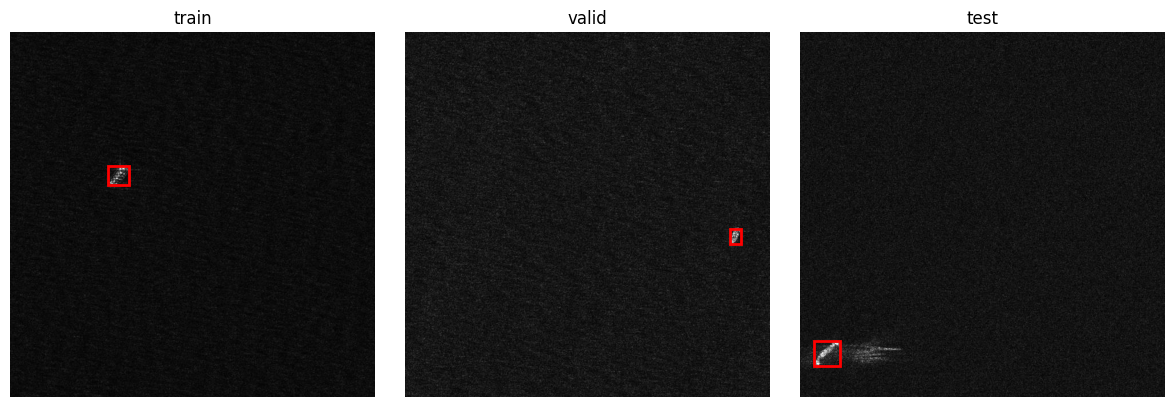

In [8]:
import random

def plot_boxes(ax, img_path, label_path):
    img = Image.open(img_path)
    w, h = img.size
    ax.imshow(img)
    ax.axis("off")

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f.readlines():
                class_id, xc, yc, bw, bh = map(float, line.strip().split())
                x_center = xc * w
                y_center = yc * h
                box_w = bw * w
                box_h = bh * h
                x_min = x_center - box_w / 2
                y_min = y_center - box_h / 2
                rect = patches.Rectangle(
                    (x_min, y_min), box_w, box_h,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                # ax.text(x_min, y_min-5, f"{int(class_id)}", color='yellow', fontsize=8, weight='bold')

# base directories
img_base = "/kaggle/working/rt-detr/images"
label_base = "/kaggle/working/rt-detr/labels"
# splits = ["train", "valid", "test"]

fig, axes = plt.subplots(1, 3, figsize=(12,4))  # 1 row, 3 images
for ax, split in zip(axes, splits):
    imgs = [f for f in os.listdir(os.path.join(img_base, split)) if f.endswith((".jpg",".png"))]
    img_file = random.choice(imgs)
    img_path = os.path.join(img_base, split, img_file)
    label_path = os.path.join(label_base, split, os.path.splitext(img_file)[0]+".txt")
    plot_boxes(ax, img_path, label_path)
    ax.set_title(split)

plt.tight_layout()
plt.show()


### 1. RT-DETR Large

#### 1.1 Model training

In [9]:
# Load pretrained model
model = RTDETR('rtdetr-l.pt')

In [10]:
# train
train_results = model.train(
    data="/kaggle/working/rt-detr/dataset.yaml",  
    epochs=20,
    batch=16,
    imgsz=640
)

Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rt-detr/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

In [11]:
# Load training results
results_path = '/kaggle/working/runs/detect/train/results.csv'

results = pd.read_csv(results_path)
results.columns = results.columns.str.strip() # Clean column names 

print("\nFirst few rows:")
print(results.head())



First few rows:
   epoch      time  train/giou_loss  train/cls_loss  train/l1_loss  \
0      1   379.839          0.65011         0.85265        0.11698   
1      2   750.812          0.55281         0.48617        0.08365   
2      3  1118.460          0.53775         0.47083        0.07348   
3      4  1484.590          0.50725         0.45682        0.06892   
4      5  1852.070          0.50212         0.45953        0.06949   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.85094            0.70055           0.79278   
1               0.85068            0.72917           0.83029   
2               0.88122            0.78974           0.87689   
3               0.87360            0.77320           0.85785   
4               0.88213            0.79573           0.87817   

   metrics/mAP50-95(B)  val/giou_loss  val/cls_loss  val/l1_loss    lr/pg0  \
0              0.49651        0.44815       0.46834      0.09008  0.000664   
1              0.5260

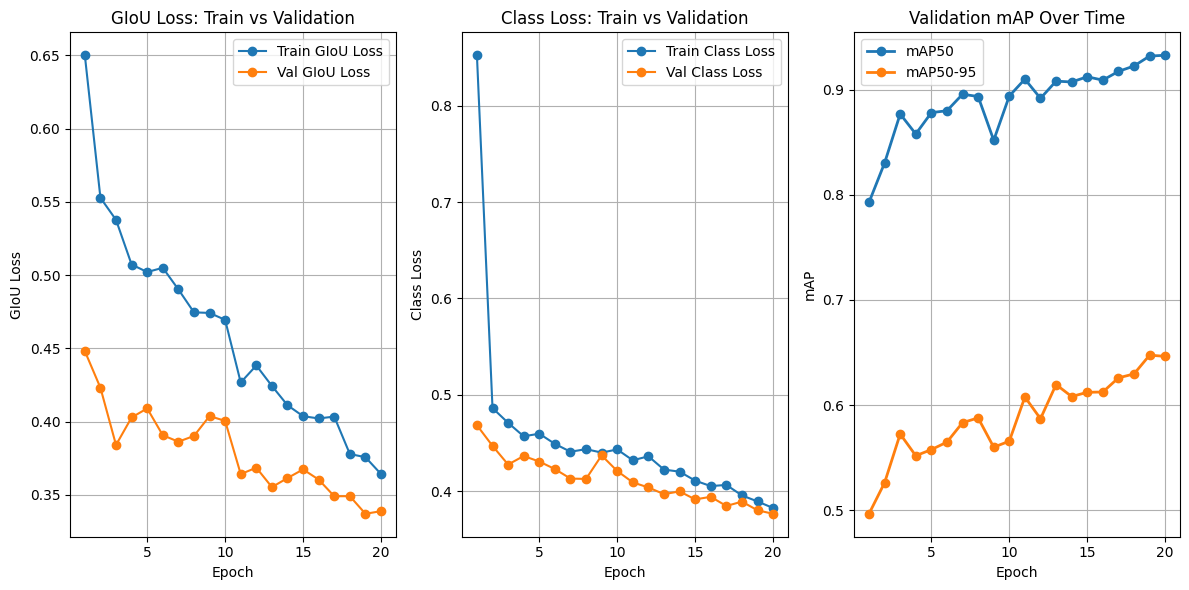

In [12]:
plot_curve(results)

#### 1.2 Testing

In [13]:
# Load your trained model
best_model = RTDETR('/kaggle/working/runs/detect/train/weights/best.pt')

test_results = best_model.val(data='/kaggle/working/rt-detr/dataset.yaml', split='test', plots= True)

Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 310 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1165.7±518.9 MB/s, size: 57.4 KB)
val: Scanning /kaggle/working/rt-detr/labels/test... 672 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 672/672 1.5Kit/s 0.5s0.1ss
val: New cache created: /kaggle/working/rt-detr/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 42/42 1.4it/s 30.9s0.8ss
                   all        672       2014      0.901      0.851      0.915      0.625
Speed: 1.0ms preprocess, 41.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


#### 1.3 Prediction

In [14]:
best_model = RTDETR('/kaggle/working/runs/detect/train/weights/best.pt')

# predict
predict = best_model.predict("/kaggle/working/rt-detr/images/test/*", conf = 0.5)


image 1/672 /kaggle/working/rt-detr/images/test/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg: 640x640 1 ship, 63.4ms
image 2/672 /kaggle/working/rt-detr/images/test/000047_jpg.rf.a7c5a75819459815e026bd5f7c0c5d3d.jpg: 640x640 2 ships, 49.9ms
image 3/672 /kaggle/working/rt-detr/images/test/000059_jpg.rf.e7369a146592d0d45241a640ac951d5c.jpg: 640x640 5 ships, 50.5ms
image 4/672 /kaggle/working/rt-detr/images/test/000062_jpg.rf.74c3c4bcb7a59fb971a4bbe573235055.jpg: 640x640 1 ship, 49.6ms
image 5/672 /kaggle/working/rt-detr/images/test/000069_jpg.rf.34afecb18bccfc3ce078330ec0d18094.jpg: 640x640 2 ships, 49.9ms
image 6/672 /kaggle/working/rt-detr/images/test/000086_jpg.rf.bbc50f90494434e8ea43df96263ff54a.jpg: 640x640 1 ship, 44.7ms
image 7/672 /kaggle/working/rt-detr/images/test/000096_jpg.rf.2ceab787373bba737023b8fced5b2cb0.jpg: 640x640 1 ship, 43.8ms
image 8/672 /kaggle/working/rt-detr/images/test/000097_jpg.rf.7ee59769af8798229e3743973e1f6c53.jpg: 640x640 4 ships, 45.1ms
image 9/672

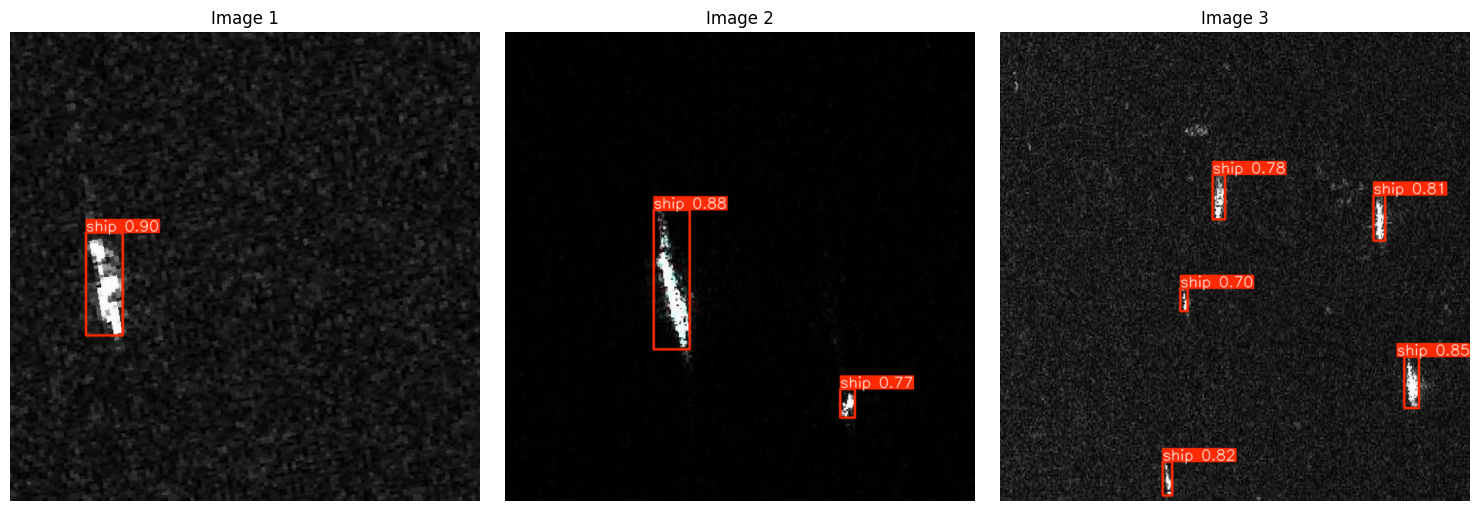

In [15]:
prediction_plot(predict, num_images=3, images_per_row = 3, scale= 5)

In [16]:
# save outputs
shutil.make_archive("/kaggle/working/runs_rtdetrl_zip", 'zip', "/kaggle/working/runs/")

'/kaggle/working/runs_rtdetrl_zip.zip'

### 2. RE-DETR Extra Large

#### 2.1 Model Training

In [29]:
del model2
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [9]:
# Load pretrained model
model2 = RTDETR('rtdetr-x.pt')

In [ ]:
# train
train_results2 = model2.train(
    data="/kaggle/working/rt-detr/dataset.yaml",  
    epochs=20,
    batch=16,
    imgsz=640
)

In [ ]:
# Load training results
results_path2 = '/kaggle/working/runs/detect/train/results.csv' #confirm path

results2 = pd.read_csv(results_path2)
results2.columns = results2.columns.str.strip() # Clean column names
print(results2.head())


In [ ]:
# plot the curves
plot_curve(results2)

#### 2.2 Model Testing

In [ ]:
# Load your trained model
best_model2 = RTDETR('/kaggle/working/runs/detect/train/weights/best.pt') #confirm path

# test model
test_results2 = best_model2.val(data='/kaggle/working/rt-detr/dataset.yaml', split='test', plots= True)

#### 2.3 Prediction

In [ ]:
# predict
predict2 = best_model2.predict("/kaggle/working/rt-detr/images/test/*", 
                             conf = 0.5,
                             save=True)

In [ ]:
# plot prediction
prediction_plot(predict2, num_images=3, images_per_row = 3, scale= 5)

In [25]:
# save outputs
shutil.make_archive("/kaggle/working/runs_rtdetrx_zip", 'zip', "/kaggle/working/runs/")

'/kaggle/working/runs_v2_zip.zip'